In [1]:
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
#数据集小型中英数据集
!wget http://www.manythings.org/anki/cmn-eng.zip
!unzip -d ./cmn-eng cmn-eng.zip

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--en_path', type=str, default='data/news-commentary-v13.zh-en.en',
                   help='英文数据集路径')
parser.add_argument('--zh_path', type=str, default='data/news-commentary-v13.zh-en.zh',
                   help='中文数据集路径')
parser.add_argument('--seq_len', type=int, default=60,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=512,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attention',type=bool,default=False,
                   help='是否启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]


In [4]:
# with open(kwargs.en_path, 'r') as f_en:
#     data_en = f_en.readlines()
# with open(kwargs.zh_path, 'r') as f_zh:
#     data_zh = f_zh.readlines()

In [5]:
#用一个小数据集合先玩玩
with open('./cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
# 分割英文数据和中文数据
data_en = [line.split('\t')[0] for line in data]
data_zh = [line.split('\t')[1] for line in data]

In [6]:
#特殊处理
def data_process(text):
    text = text.lower()
    # 特殊数据处理，该地方可以各种替换缩略词等
    # 去除标点等
    return text

In [7]:
#对单句话进行分词
def get_token_text(text_en,text_zh):
    #简单的句子处理
    text_en=text_en.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    text_zh=text_zh.strip('\n')
    #英文以空格分割
    token_data_en = [data_process(st) for st in text_en.split()]
    #中文一般用jieba
    token_data_zh = [data_process(st) for st in jieba.cut(text_zh)]
    return [token_data_en,token_data_zh]

In [8]:
#对两个数据集的每句话进行分词
def get_token_data(data_en,data_zh):
    data_token_en = []
    data_token_zh = []
    for en,zh in zip(data_en,data_zh):
        en,zh=get_token_text(en,zh)
        data_token_en.append(en)
        data_token_zh.append(zh)
    return data_token_en,data_token_zh

In [9]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(100000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [11]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        feature.append(2)
        features.append(feature)
    
    return features

In [12]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
#en_data,zh_data=get_token_data(data_en,data_zh)
#字符级
en_data = [[char for char in line] for line in data_en]
zh_data = [[char for char in line] for line in data_zh]

In [13]:
print(en_data[0:2],zh_data[0:2])

[['H', 'i', '.'], ['H', 'i', '.']] [['嗨', '。'], ['你', '好', '。']]


In [14]:
vocab_en,vocab_size_en, word_to_idx_en, idx_to_word_en=get_vocab(en_data)
vocab_zh,vocab_size_zh, word_to_idx_zh, idx_to_word_zh=get_vocab(zh_data)


In [15]:
kwargs.vocab_size_en=vocab_size_en#记录vocab大小
kwargs.vocab_size_zh=vocab_size_zh#记录vocab大小
print(vocab_size_en,vocab_size_zh)

79 3534


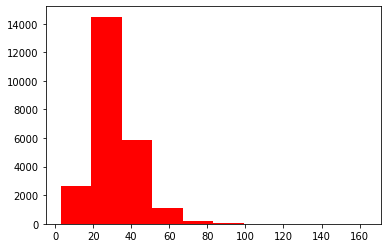

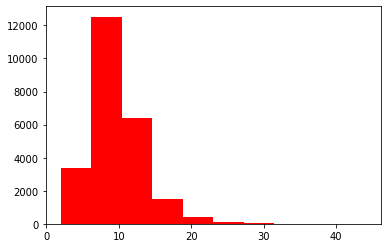

In [16]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in en_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in zh_data:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()

In [17]:
print(zh_data_length[0:10])

[2, 3, 5, 3, 4, 3, 3, 4, 4, 3]


In [18]:
en_data_id=encode_st((en_data),word_to_idx_en)
zh_data_id=encode_st((zh_data),word_to_idx_zh)

In [19]:
print(en_data_id[0:3])

[[1, 32, 10, 15, 2], [1, 32, 10, 15, 2], [1, 61, 17, 11, 15, 2]]


In [20]:
from torch.utils.data import Dataset, DataLoader
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [21]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        word_to_idx_en
        d["src"].extend([word_to_idx_en["<pad>"]]*(src_max-d["src_len"]))
        d["trg"].extend([word_to_idx_zh["<pad>"]]*(trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    return batch

In [29]:
# 数据集
train_set = TranslationDataset(en_data_id, zh_data_id)
train_iter = DataLoader(train_set, batch_size=kwargs.batch_size, collate_fn=padding_batch)

In [24]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size_en
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size_zh
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        bidirectional=True
        if bidirectional==True:
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
        else:
            self.out = nn.Linear(self.hid_dim, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell):
        batch_size = x.size(0)
        embedded = self.dropout(self.embedding(x).view(1, batch_size, -1))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
        output = self.out(output.squeeze(0))
        prediction = self.softmax(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.attention=args.attention
        self.encoder = Encoder(args)
        if self.attention==True:
            self.decoder = DecoderAtten(args)
        else:
            self.decoder = Decoder(args)
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, src_length,trg_length,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_target_length = max(trg_length)
        outputs = torch.zeros(max_target_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(src,src_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = trg[0]
        
        for t in range(max_target_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    output, hidden, cell = self.decoder(de_input, hidden, cell)
                    outputs[t] = output
                    output = trg[t]  # 下一个输入来自训练数据
            else:
                    output, decoder_hidden, cell = self.decoder(de_input, hidden, cell)
                    # [batch, 1]
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  # 
        return outputs

In [31]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.NLLLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        n= 0
        model.train()
        for i,(batch) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]
            optimizer.zero_grad()
            output = model(input_batchs, target_batchs,input_lens,target_lens)
            #print(output.is_contiguous(),trg.is_contiguous())
#             output = output.contiguous().view(-1, output.shape[-1])
#             target_batchs = target_batchs.contiguous().view(-1)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        end = time.time()
        runtime = end - start
        print(
            'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
        )

In [26]:
model=Seq2Seq(kwargs,device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(79, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(3534, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (out): Linear(in_features=1024, out_features=3534, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


In [36]:
train(kwargs,device,model,train_iter)

  0%|          | 0/48 [00:00<?, ?it/s]

模型开始训练


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 0, train loss: 0.6755,time: 17.9027 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1, train loss: 0.6620,time: 17.8078 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2, train loss: 0.6630,time: 17.7908 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3, train loss: 0.6600,time: 17.7947 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4, train loss: 0.6494,time: 17.9183 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5, train loss: 0.6298,time: 17.9115 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6, train loss: 0.6310,time: 17.9454 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7, train loss: 0.6438,time: 17.8366 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8, train loss: 0.6347,time: 17.8645 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9, train loss: 0.6261,time: 17.9821 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10, train loss: 0.6183,time: 17.8759 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 11, train loss: 0.6065,time: 17.9256 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 12, train loss: 0.6113,time: 17.8381 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 13, train loss: 0.6010,time: 17.9255 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 14, train loss: 0.6036,time: 17.9690 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 15, train loss: 0.5951,time: 17.9065 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 16, train loss: 0.5950,time: 17.8854 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 17, train loss: 0.5866,time: 17.8174 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 18, train loss: 0.5765,time: 17.8247 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 19, train loss: 0.5885,time: 17.9497 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 20, train loss: 0.5709,time: 18.0074 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 21, train loss: 0.5554,time: 17.9359 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 22, train loss: 0.5480,time: 17.7544 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 23, train loss: 0.5558,time: 17.8590 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 24, train loss: 0.5519,time: 17.8951 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 25, train loss: 0.5611,time: 18.0401 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 26, train loss: 0.5685,time: 17.9180 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 27, train loss: 0.5588,time: 18.0254 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 28, train loss: 0.5722,time: 17.9731 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 29, train loss: 0.5479,time: 17.8397 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 30, train loss: 0.5286,time: 17.8438 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 31, train loss: 0.5486,time: 17.9188 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 32, train loss: 0.5447,time: 17.9116 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 33, train loss: 0.5347,time: 17.9285 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 34, train loss: 0.5239,time: 17.9323 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 35, train loss: 0.5118,time: 17.9234 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 36, train loss: 0.5214,time: 17.8931 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 37, train loss: 0.5143,time: 17.9696 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 38, train loss: 0.5243,time: 17.9760 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 39, train loss: 0.5486,time: 17.9857 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 40, train loss: 0.5548,time: 17.9983 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 41, train loss: 0.5563,time: 18.0473 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 42, train loss: 0.6113,time: 17.9870 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 43, train loss: 0.6346,time: 18.0128 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 44, train loss: 0.6237,time: 17.9965 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 45, train loss: 0.6108,time: 17.9776 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 46, train loss: 0.5568,time: 17.9745 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 47, train loss: 0.5406,time: 17.9509 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 48, train loss: 0.5292,time: 17.9492 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 49, train loss: 0.4966,time: 17.9250 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 50, train loss: 0.5139,time: 17.9107 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 51, train loss: 0.5050,time: 17.9020 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 52, train loss: 0.5094,time: 17.9950 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 53, train loss: 0.5132,time: 18.0014 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 54, train loss: 0.5247,time: 17.9242 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 55, train loss: 0.5116,time: 17.9625 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 56, train loss: 0.5172,time: 17.9694 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 57, train loss: 0.5036,time: 17.9695 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 58, train loss: 0.5171,time: 17.9888 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 59, train loss: 0.5025,time: 17.8976 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 60, train loss: 0.5284,time: 17.9569 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 61, train loss: 0.5352,time: 17.9088 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 62, train loss: 0.5045,time: 17.9632 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 63, train loss: 0.5000,time: 17.9865 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 64, train loss: 0.4799,time: 17.9165 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 65, train loss: 0.4896,time: 17.9043 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 66, train loss: 0.4953,time: 17.9530 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 67, train loss: 0.4722,time: 17.9700 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 68, train loss: 0.4814,time: 18.0619 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 69, train loss: 0.5047,time: 18.0512 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 70, train loss: 0.4920,time: 17.9754 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 71, train loss: 0.4723,time: 17.9575 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 72, train loss: 0.4664,time: 17.9538 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 73, train loss: 0.4528,time: 17.8805 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 74, train loss: 0.4679,time: 17.8878 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 75, train loss: 0.4524,time: 17.9793 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 76, train loss: 0.4689,time: 17.9927 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 77, train loss: 0.5075,time: 17.9835 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 78, train loss: 0.4659,time: 17.9139 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 79, train loss: 0.4558,time: 17.9435 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 80, train loss: 0.4600,time: 17.9565 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 81, train loss: 0.4507,time: 17.8282 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 82, train loss: 0.4421,time: 18.1163 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 83, train loss: 0.4646,time: 17.9911 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 84, train loss: 0.4477,time: 18.0076 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 85, train loss: 0.4564,time: 18.0020 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 86, train loss: 0.4617,time: 18.0254 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 87, train loss: 0.4462,time: 17.9619 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 88, train loss: 0.4601,time: 17.9723 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 89, train loss: 0.4652,time: 18.0759 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 90, train loss: 0.4705,time: 17.9397 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 91, train loss: 0.4613,time: 18.0220 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 92, train loss: 0.4333,time: 17.9882 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 93, train loss: 0.4700,time: 17.9922 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 94, train loss: 0.4706,time: 17.8502 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 95, train loss: 0.4515,time: 17.8246 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 96, train loss: 0.4442,time: 17.9390 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 97, train loss: 0.4503,time: 17.9044 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 98, train loss: 0.4301,time: 18.0237 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 99, train loss: 0.4321,time: 17.8404 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 100, train loss: 0.4182,time: 17.9142 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 101, train loss: 0.4110,time: 17.9612 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 102, train loss: 0.4264,time: 17.9218 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 103, train loss: 0.4100,time: 17.9805 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 104, train loss: 0.4096,time: 17.8186 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 105, train loss: 0.4072,time: 17.9740 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 106, train loss: 0.4302,time: 17.8189 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 107, train loss: 0.3959,time: 17.8466 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 108, train loss: 0.4104,time: 17.8856 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 109, train loss: 0.4216,time: 17.9520 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 110, train loss: 0.4017,time: 17.9602 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 111, train loss: 0.4147,time: 18.0335 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 112, train loss: 0.4333,time: 17.9541 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 113, train loss: 0.4106,time: 17.9060 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 114, train loss: 0.4394,time: 17.9779 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 115, train loss: 0.4462,time: 18.0312 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 116, train loss: 0.4299,time: 17.8899 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 117, train loss: 0.4172,time: 17.9096 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 118, train loss: 0.4293,time: 17.8774 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 119, train loss: 0.4023,time: 17.9474 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 120, train loss: 0.4064,time: 17.9689 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 121, train loss: 0.4055,time: 17.9741 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 122, train loss: 0.4029,time: 17.9288 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 123, train loss: 0.3851,time: 18.0610 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 124, train loss: 0.3860,time: 18.0026 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 125, train loss: 0.3912,time: 17.9516 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 126, train loss: 0.4161,time: 17.9819 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 127, train loss: 0.3946,time: 17.9532 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 128, train loss: 0.3845,time: 17.9242 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 129, train loss: 0.4050,time: 17.9191 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 130, train loss: 0.4623,time: 18.0217 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 131, train loss: 0.4605,time: 17.9756 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 132, train loss: 0.4765,time: 17.9090 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 133, train loss: 0.4361,time: 17.9287 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 134, train loss: 0.3977,time: 17.9268 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 135, train loss: 0.3764,time: 17.9095 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 136, train loss: 0.3763,time: 17.9153 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 137, train loss: 0.3799,time: 17.9479 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 138, train loss: 0.3628,time: 17.8869 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 139, train loss: 0.3717,time: 17.9285 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 140, train loss: 0.3680,time: 17.8554 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 141, train loss: 0.3524,time: 18.0093 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 142, train loss: 0.3728,time: 17.9439 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 143, train loss: 0.3758,time: 17.9685 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 144, train loss: 0.3642,time: 18.0650 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 145, train loss: 0.3765,time: 17.8937 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 146, train loss: 0.3762,time: 17.9692 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 147, train loss: 0.3874,time: 17.9069 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 148, train loss: 0.3930,time: 17.9771 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 149, train loss: 0.3690,time: 18.0635 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 150, train loss: 0.3677,time: 17.9354 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 151, train loss: 0.3650,time: 18.0514 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 152, train loss: 0.3970,time: 18.0528 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 153, train loss: 0.3798,time: 17.9325 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 154, train loss: 0.3930,time: 17.9558 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 155, train loss: 0.3847,time: 18.0459 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 156, train loss: 0.3708,time: 18.0316 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 157, train loss: 0.3918,time: 17.9309 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 158, train loss: 0.3785,time: 17.8587 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 159, train loss: 0.3758,time: 17.8643 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 160, train loss: 0.4010,time: 17.9776 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 161, train loss: 0.4224,time: 18.0100 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 162, train loss: 0.3797,time: 18.0655 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 163, train loss: 0.4247,time: 18.0804 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 164, train loss: 0.4084,time: 17.9496 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 165, train loss: 0.4199,time: 17.9958 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 166, train loss: 0.4228,time: 17.9952 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 167, train loss: 0.3979,time: 17.8772 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 168, train loss: 0.4336,time: 17.9995 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 169, train loss: 0.4440,time: 18.0451 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 170, train loss: 0.4018,time: 18.0336 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 171, train loss: 0.3920,time: 17.9778 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 172, train loss: 0.3779,time: 18.0259 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 173, train loss: 0.3661,time: 17.8783 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 174, train loss: 0.3506,time: 17.9875 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 175, train loss: 0.3606,time: 18.0236 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 176, train loss: 0.3467,time: 17.8933 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 177, train loss: 0.3401,time: 17.9628 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 178, train loss: 0.3407,time: 18.0399 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 179, train loss: 0.3507,time: 18.0016 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 180, train loss: 0.3637,time: 18.0383 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 181, train loss: 0.3586,time: 17.9293 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 182, train loss: 0.3692,time: 17.8935 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 183, train loss: 0.3693,time: 18.0695 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 184, train loss: 0.3886,time: 17.9128 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 185, train loss: 0.3731,time: 17.9349 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 186, train loss: 0.3569,time: 17.9215 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 187, train loss: 0.3561,time: 17.9417 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 188, train loss: 0.3527,time: 17.9654 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 189, train loss: 0.3500,time: 17.9738 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 190, train loss: 0.3544,time: 17.9266 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 191, train loss: 0.3441,time: 17.8884 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 192, train loss: 0.3512,time: 17.9301 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 193, train loss: 0.3596,time: 17.8598 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 194, train loss: 0.3423,time: 18.0483 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 195, train loss: 0.3412,time: 17.9681 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 196, train loss: 0.3518,time: 17.9155 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 197, train loss: 0.3305,time: 18.0773 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 198, train loss: 0.3588,time: 18.0883 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 199, train loss: 0.3673,time: 17.9995 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 200, train loss: 0.3623,time: 18.0572 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 201, train loss: 0.3576,time: 17.8820 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 202, train loss: 0.3546,time: 18.0190 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 203, train loss: 0.3540,time: 17.8771 



100%|██████████| 48/48 [00:18<00:00,  2.66it/s]

epoch: 204, train loss: 0.3738,time: 18.0467 



In [42]:
torch.save(model, 's2s_zifu.pkl')

In [43]:
#简单测试一下，选第14个数据集进行测试
for i,(batch) in enumerate(tqdm(train_iter)):
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]

            output = model(input_batchs, target_batchs,input_lens,target_lens)
            if i==14:
                break
print(output.shape)
output=output.argmax(2)
print(output.shape)
print(input_batchs.shape)
input_batchs=input_batchs.transpose(1,0)
output=output.transpose(1,0)
target_batchs=target_batchs.transpose(1,0)
for z,i in enumerate(output):
    print('\n原文：')
    for j in input_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_en[j.item()],end='')
    print('\n正确答案：')
    for j in target_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')
    print('\n预测')
    for j in i:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')



 29%|██▉       | 14/48 [00:01<00:04,  8.24it/s]


torch.Size([16, 512, 3534])
torch.Size([16, 512])
torch.Size([27, 512])

原文：
<sos>I doubt if Tom is single.
正确答案：
<sos>我怀疑汤姆是单身。
预测
<sos>我怀疑汤姆单单。
原文：
<sos>I feel like another beer.
正确答案：
<sos>我想再来一杯啤酒。
预测
<sos>我想再来杯杯酒。
原文：
<sos>I feel much better today.
正确答案：
<sos>我今天感觉好多了。
预测
<sos>我今天感觉好多。
原文：
<sos>I gave Tom three cookies.
正确答案：
<sos>我给了汤姆三块饼干。
预测
<sos>我给了汤三块饼干。
原文：
<sos>I get a kick out of life.
正确答案：
<sos>我為人生感到很開心。
预测
<sos>我為人生到很心。
原文：
<sos>I go to church every day.
正确答案：
<sos>我每天上教堂。
预测
<sos>我每天教教。
原文：
<sos>I go to church on Sunday.
正确答案：
<sos>周日我去做礼拜。
预测
<sos>周日我去礼礼。
原文：
<sos>I go to school by subway.
正确答案：
<sos>我搭地铁上学。
预测
<sos>我搭地铁上。
原文：
<sos>I go to school by subway.
正确答案：
<sos>我坐地鐵上學。
预测
<sos>我搭地上学。
原文：
<sos>I go to school here, too.
正确答案：
<sos>我也在这儿上学。
预测
<sos>我也在这上学。
原文：
<sos>I got a hole in my jeans.
正确答案：
<sos>我的牛仔褲破了一個洞。
预测
<sos>我的牛仔破了一一洞。
原文：
<sos>I got lost in the forest.
正确答案：
<sos>我在树林里迷路了。
预测
<sos>我在树林迷路路。
原文：
<sos>I got my notebook stolen.
正确答案：
<sos>有人把我的筆記本電腦偷掉了。

<sos>我可以問一些題嗎
原文：
<sos>May I ask you a question?
正确答案：
<sos>我可以问你个问题吗？
预测
<sos>我可以问个问题吗？
原文：
<sos>May I go to the bathroom?
正确答案：
<sos>我可以去洗手間嗎？
预测
<sos>我可以洗手間間？
原文：
<sos>May I go to the restroom?
正确答案：
<sos>我可以去洗手間嗎？
预测
<sos>我可以洗手間嗎？
原文：
<sos>May I see you in private?
正确答案：
<sos>我們能私下見見嗎？
预测
<sos>我們能下下見嗎？
原文：
<sos>Mother has a coffee shop.
正确答案：
<sos>媽媽有一個咖啡廳。
预测
<sos>媽媽有一咖啡啡。
原文：
<sos>Mt. Asama is now dormant.
正确答案：
<sos>浅间山现在是寂静的。
预测
<sos>浅间山在在寂的的。
原文：
<sos>My aunt gave me a camera.
正确答案：
<sos>我的阿姨給了我一台攝影機。
预测
<sos>我的阿姨我我一攝攝機機
原文：
<sos>My aunt gave me an album.
正确答案：
<sos>我姑姑給了我一張唱片專輯。
预测
<sos>我姑給了我一本集郵。
原文：
<sos>My aunt gave me an album.
正确答案：
<sos>我姑姑給了我一本相簿。
预测
<sos>我姑姑了我一本集郵。。
原文：
<sos>My aunt gave me an album.
正确答案：
<sos>我姑姑給了我一本集郵冊。
预测
<sos>我姑姑給我一本集郵。。
原文：
<sos>My blood pressure is low.
正确答案：
<sos>我的血压很低。
预测
<sos>我的血很很。
原文：
<sos>My father drives to work.
正确答案：
<sos>我父親開車去上班。
预测
<sos>我父親開去上班。
原文：
<sos>My father gave me a game.
正确答案：
<sos>我爸爸给我了游戏。
预测
<sos>我爸爸我我游戏。
原文：
<sos>My f

<sos>那不是我故意的。
预测
<sos>那不是我初意。
原文：
<sos>That's a stupid question.
正确答案：
<sos>这是一个愚蠢的问题。
预测
<sos>这是一个愚的问题。
原文：
<sos>That's against the rules.
正确答案：
<sos>这违反规则。
预测
<sos>违违反规则
原文：
<sos>That's my favorite chair.
正确答案：
<sos>那是我最喜歡的椅子。
预测
<sos>那是我最歡的椅子
原文：
<sos>That's quite meaningless.
正确答案：
<sos>这毫无意义。
预测
<sos>这无无义义
原文：
<sos>That's very sweet of you.
正确答案：
<sos>您真是太好了。
预测
<sos>您真太好了。
原文：
<sos>That's what I always say.
正确答案：
<sos>那是我經常說的。
预测
<sos>那是我常的的
原文：
<sos>That's what I have to do.
正确答案：
<sos>那是我必須做的。
预测
<sos>那是我須做的。
原文：
<sos>That's what Tom promised.
正确答案：
<sos>那是汤姆承诺的。
预测
<sos>那是汤姆诺的。
原文：
<sos>The Hilton Hotel, please.
正确答案：
<sos>请开到希尔顿酒店。
预测
<sos>请开到尔尔顿店店
原文：
<sos>The baby cried all night.
正确答案：
<sos>這孩子哭了一整夜。
预测
<sos>這孩哭了了整整。
原文：
<sos>The bell hasn't rung yet.
正确答案：
<sos>钟还没响。
预测
<sos>钟还响响。
原文：
<sos>The blanket is still wet.
正确答案：
<sos>这个毯子还是湿的。
预测
<sos>这个毯子是湿的。
原文：
<sos>The boy can count to ten.
正确答案：
<sos>这小男孩能数到十。
预测
<sos>这小男能数十十。
原文：
<sos>The car is in the garage.
正确答案：
<sos>车在

<sos>那時嬰兒正在哭嗎？
预测
<sos>那時嬰兒在在嗎？
原文：
<sos>Wash your face and hands.
正确答案：
<sos>洗你的臉和手。
预测
<sos>洗你的臉手。
原文：
<sos>We accept your challenge.
正确答案：
<sos>我們接受你們的挑戰。
预测
<sos>我們接你們的挑戰。
原文：
<sos>We bought a pound of tea.
正确答案：
<sos>我們買了一磅的茶。
预测
<sos>我們買了磅的茶。
原文：
<sos>We buy eggs by the dozen.
正确答案：
<sos>鸡蛋是论打买的。
预测
<sos>鸡蛋是打买的。
原文：
<sos>We didn't get an apology.
正确答案：
<sos>我们没有收到过道歉。
预测
<sos>我们没有到过歉歉。
原文：
<sos>We didn't start the fire.
正确答案：
<sos>我们没点火。
预测
<sos>我们没点火
原文：
<sos>We do what we want to do.
正确答案：
<sos>我們做我們想做的。
预测
<sos>我們做我們做的
原文：
<sos>We expect a lot from him.
正确答案：
<sos>我們對他期望很多。
预测
<sos>我們對他期很多。
原文：
<sos>We go to school to study.
正确答案：
<sos>我們去學校學習。
预测
<sos>我們去校校學。
原文：
<sos>We go to the same school.
正确答案：
<sos>我們上同一所學校。
预测
<sos>我們上一所學校。
原文：
<sos>We got up after midnight.
正确答案：
<sos>我们在午夜之后起床。
预测
<sos>我们在夜夜后起床。
原文：
<sos>We had some chicken soup.
正确答案：
<sos>我們喝了些雞湯。
预测
<sos>我們喝些湯湯。
原文：
<sos>We have the same problem.
正确答案：
<sos>你的问题和我的一样。
预测
<sos>你的问和和的样。。
原文：
<sos>We import tea from 